In [1]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import microatoll_sim.simulator as sim
import microatoll_sim.analytical_simulator as asim

# Iterative simulator


In [2]:
sim.SimParams?

Init signature:
sim.SimParams(
    vert_shift: float,
    gr_mean: float,
    d: float,
    dt: float,
    T0: int,
    delta_T: int,
    init_radius: float,
) -> None
Docstring:     
Contains the parameters used to control the coral growth simulation.
- `vert_shift`: (units: m) Added to the provided sea level curve, to simulate the coral being present higher/lower on the reef
- `gr_mean`: (units: mm/yr) The growth rate, how thick the coral grows per year
- `d` : (units: mm) Controls how finely the new coral band should be resampled. Represents the arc-length distance between resampled points.
- `dt`: (units: year) 1/dt is how many bands grow in a year. This controls the resolution of the bands. It can be made very fine for more precise simulation.
- `T0`: (unit: year) When in the sea level time series to start the simulation
- `delta_T`: (unit: years) Time period for coral growth simulation
- `init_radius`: (unit: m) Initial radius of the coral, from which the simulation starts
- `num

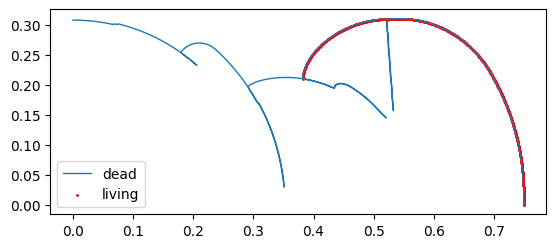

In [3]:
params = sim.SimParams(
    vert_shift=0.4,
    gr_mean=15,
    d=1.0,
    dt=0.1,  # will have 1/dt = 10 bands/yr
    T0=1980,
    delta_T=30,
    init_radius=0.3,
)

sl_df = pd.read_csv("./data/SeaLevel.csv", header=None, names=["time", "sl"])
sl_arr = sl_df.to_numpy()
sl_arr[:, 1] += params.vert_shift
band_sl_arr = sim.lowest_discreet(
    sl_arr, params.dt, params.T0, params.T0 + params.delta_T
)
# can change this for variable growth rate!
gr_vec = np.ones(params.NT) * params.gr_mean
# simulation
lines, living_statuses = sim.coral_growth_all(
    params.init_radius,
    params.num_initial_pts,
    params.d,
    gr_vec,
    params.NT,
    band_sl_arr[:, 1],
)
line = lines[-1]
living_status = living_statuses[-1].astype(bool)

plt.plot(line[:, 0], line[:, 1], lw=1, label="dead")
plt.scatter(
    line[:, 0][living_status], line[:, 1][living_status], s=1, c="r", label="living"
)
plt.gca().set_aspect(1)
plt.legend()
plt.show()

In [35]:
params.gr_mean * params.NT + params.init_radius

0.75

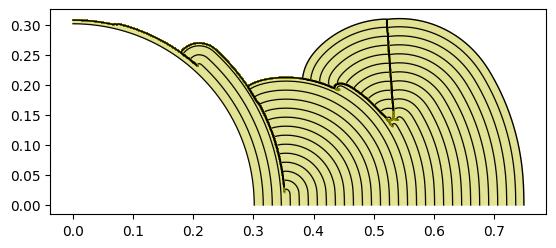

In [4]:
for i, line in enumerate(lines):
    if i % (1 / params.dt) == 0:
        # annual bands in black
        plt.plot(line[:, 0], line[:, 1], lw=1, c="black")
    else:
        plt.plot(line[:, 0], line[:, 1], lw=1, c="y", alpha=0.3)

plt.gca().set_aspect(1)
plt.show()

# Analytical solution simulator

Not every inner layer is simulated, and the overgrowth is ignored.


In [43]:
gr = 15 * 1e-3
vert_shift = params.vert_shift
T0 = params.T0
delta_T = params.delta_T
init_radius = params.init_radius
dt = params.dt

gr, vert_shift, T0, delta_T, init_radius, dt

(0.015, 0.4, 1980, 30.000300000000003, 0.3, 0.1)

In [63]:
sl_df = pd.read_csv("./data/SeaLevel.csv", header=None, names=["time", "sl"])
sl_arr = sl_df.to_numpy()
sl_arr[:, 1] += vert_shift
band_sl_arr = sim.lowest_discreet(sl_arr, 0.1, T0, T0 + delta_T)

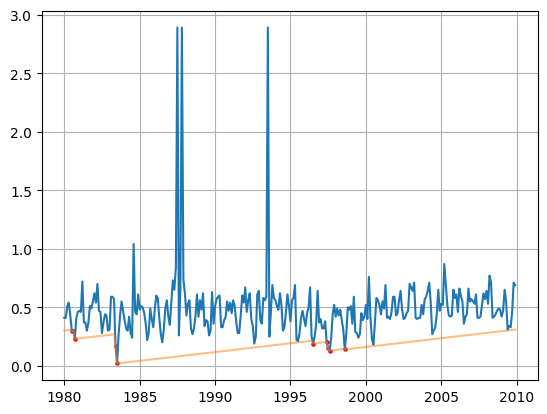

11


In [64]:
x, y = band_sl_arr[:, 0], band_sl_arr[:, 1]
# x= x[:100]
# y = y[:100]
plt.plot(x, y)
plt.grid()


hlg_curve = [init_radius]
diedown_events = []
step = x[1] - x[0]
for i in range(len(x)):
    a, b = hlg_curve[-1] + gr * step, y[i]
    if a <= b:
        hlg_curve.append(a)
    else:
        hlg_curve.append(b)
        diedown_events.append((x[i], b))

diedown_events = np.array(diedown_events)
plt.plot(x, hlg_curve[1:], alpha=0.5)
plt.scatter(diedown_events[:, 0], diedown_events[:, 1], c="r", s=5)
plt.show()
diedown_events = np.vstack([diedown_events, [x[-1], hlg_curve[-1]]])
init_time = diedown_events[0, 1] / gr
diedown_events[:, 0] = diedown_events[:, 0] - diedown_events[0, 0] + init_time
# diedown_events[1:,0] = diedown_events[1:,0]#*1.5
print(len(diedown_events))


In [65]:
diedown_events

array([[2.000e+01, 3.000e-01],
       [2.010e+01, 3.000e-01],
       [2.020e+01, 2.300e-01],
       [2.290e+01, 1.700e-01],
       [2.300e+01, 2.000e-02],
       [3.600e+01, 1.900e-01],
       [3.690e+01, 2.000e-01],
       [3.700e+01, 1.500e-01],
       [3.710e+01, 1.300e-01],
       [3.810e+01, 1.400e-01],
       [4.940e+01, 3.095e-01]])

0.30000000000000004


/Users/rohan/miniconda3/envs/microatoll_sim/lib/python3.12/site-packages/microatoll_sim/analytical_simulator.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  C = -(P2[0] - P1[0]) / (P2[1] - P1[1])
/Users/rohan/miniconda3/envs/microatoll_sim/lib/python3.12/site-packages/microatoll_sim/analytical_simulator.py:56: RuntimeWarning: invalid value encountered in scalar divide
  O[0] = (-V * P1[0] + P1[1] + C * M[0] - M[1]) / (C - V)
/Users/rohan/miniconda3/envs/microatoll_sim/lib/python3.12/site-packages/microatoll_sim/analytical_simulator.py:157: RuntimeWarning: invalid value encountered in arcsin
  Arcs[3, I, 4] = pi / 2 + np.arcsin(DD[I - 1, 0] / V)


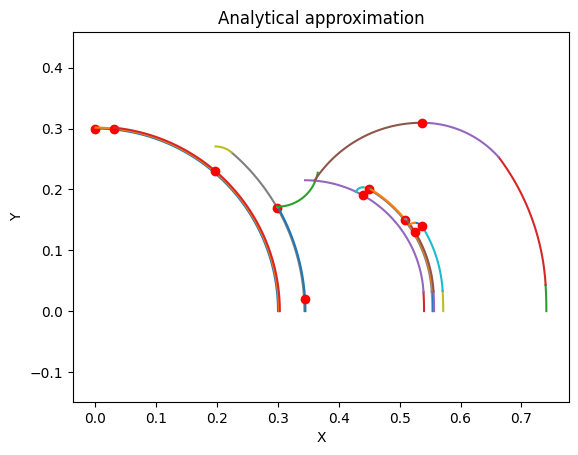

In [66]:
DATAFILE01 = "data/Sealevel.dat"
DATAFILE02 = "data/Param.dat"
pi = np.pi

SLin = np.loadtxt(DATAFILE01, comments="#")
# gr = np.loadtxt(DATAFILE02, usecols=[1])
# gr = gr / 1e3
SLin = diedown_events
Nc = SLin.shape[0]  # Number of diedown events

# Arrays for arc segments
# First column:0:BF, 1:MF, 2:TF, 3:TB
# Third column: 0:Ox, 1:Oy, 2:radius, 3:1st endpoint, 4:2nd endpoint
Arcs = np.zeros((4, Nc, 5))

# Diedown point
# Second column: 0:Dx, 1:Dy, 2:Angle of normal vector,
#               3:Location of diedown (0:BF, 1:MF, 2:TF)
DD = np.zeros((Nc, 4))

# Surface trace
Sfc = np.zeros((100, 5))
# Initial shape and diedown
R = gr * SLin[0, 0]  # radius
print(R)
# R =0.2 # radius
# print(R)
Arcs[:, 0, 2] = R
Arcs[2, 0, 4] = pi / 2
Arcs[3, 0, 3] = pi / 2
Arcs[3, 0, 4] = pi / 2

DD[0, 0] = np.sqrt((R * R) - SLin[0, 1] * SLin[0, 1])
DD[0, 1] = SLin[0, 1]
DD[0, 2] = np.arctan2(DD[0, 1], DD[0, 0])
DD[0, 3] = 0

Sfc[0, :5] = [0, 0, R, DD[0, 2], pi / 2]
Isf = 0

asim.growth(Nc, gr, Isf, SLin, Arcs, DD, Sfc)
for j in range(0, Nc):
    for i in range(0, 4):
        asim.plot_arc_segment(*Arcs[i, j, :])
    plt.plot(DD[j, 0], DD[j, 1], "ro")
